In [3]:
# |default_exp conv

In [1]:
# |export

from typing import Mapping

import torch
from torch import nn
from torch.utils.data import default_collate

In [ ]:
import miniai.datasets as ds
import miniai.training as tr

# Convolutions

Allow us to tell our network something about the structure of the problem that might make it easier to solve.

For images, images are layed out on a 2D BW/ 3D color grid. There are generally relationships between close pixels, relationships across dimensions, similar pixel often represent similar things etc.

Images have features, distinct attributes.

## Data

In [5]:
# Download the MNIST dataset
import gzip
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor
from pathlib import Path
from urllib.request import urlretrieve

MNIST_URL = "https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true"

data_path = Path("data/mnist")
data_path.mkdir(exist_ok=True)
gz_path = data_path / "mnist.pkl.gz"

mpl.rcParams["image.cmap"] = "gray"

if not gz_path.exists():
    urlretrieve(MNIST_URL, gz_path)

# File contains a tuple of tuples for the x and y, train and validation data
# Images are 28x28
with gzip.open(gz_path, "rb") as file:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(file, encoding="latin-1")

# Put into tensors
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

## Convolution equations

See [CNNs from different viewpoints](https://medium.com/impactai/cnns-from-different-viewpoints-fab7f52d159c).

Convolutions have an input (think of it as a grid) and a kernel (think of it as another grid, and as a filter).

Eg a 3x3 input:

```
ABC
DEF
GHJ
```

and a 2x2 kernel:

```
jk
lm
```

with an output:

```
PQ
RS
```

We slide the kernel along the input, putting the result in the top left of the output..

```
P = j*A + k*B + l*D + m*E + bias
```

then we "slide along one"

```
Q = j*B + k*C + l*E + m*F + bias
```

and so on for the next row of output:

```
R = j*D + k*E + l*G + m*H  + bias
S = j*E + k*F + l*H + m*J  + bias
```

<Axes: >

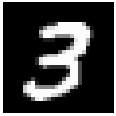

In [6]:
# Lets try and do one on one of the images, lets pick this 3

x_imgs = x_train.view(-1, 28, 28)
xv_imgs = x_valid.view(-1, 28, 28)

mpl.rcParams["figure.dpi"] = 30

im3 = x_imgs[7]
ds.show_image(im3)

<Axes: >

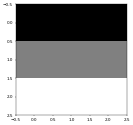

In [7]:
# Here is a kernel that trys to detect top edges
top_edge = tensor([[-1, -1, -1], [0, 0, 0], [1, 1, 1]]).float()

## It can be visualised like this
ds.show_image(top_edge, noframe=False)

What happens when we run this filter?

If we have an input of

```
a1 a2 a3
a4 a5 a6
a7 a8 a9
```

we would get

```
-a1 -a2  -a3 + a7 + a8 + a9
```

why does this matter? Consider just a section of our 3.

In [8]:
import pandas as pd

df = pd.DataFrame(im3[:13, :23])
df.style.format(precision=2).set_properties(**{"font-size": "7pt"}).background_gradient("Greys")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.17,0.41,1.00,0.99,0.99,0.99,0.99,0.99,0.68,0.02,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.54,0.88,0.88,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.62,0.05
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.70,0.98,0.98,0.98,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.23
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.98,0.98,0.90,0.52,0.52,0.52,0.52,0.74,0.98,0.98,0.98,0.98,0.23
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.11,0.11,0.09,0.00,0.00,0.00,0.00,0.05,0.88,0.98,0.98,0.67,0.03


In [9]:
# What if we take a section of the image at the top of an edge
print(im3[3:6, 14:17])

# And apply our kernel
(im3[3:6, 14:17] * top_edge).sum()

# We get a large positive value, the three negatives in our kernel are all 0s, and the 1's are all large positives

tensor([[0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.9961, 0.9883, 0.9883]])


tensor(2.9727)

In [10]:
# What if we look a the bottom of an edge
print(im3[7:10, 14:17])

# And apply our kernel
(im3[7:10, 14:17] * top_edge).sum()

# We get a large negative as now our negatives have large values and our positives are zero

tensor([[0.9883, 0.9844, 0.9844],
        [0.5195, 0.5156, 0.5156],
        [0.0000, 0.0000, 0.0000]])


tensor(-2.9570)

In [11]:
# We can put this in a function
# row,col specifis the center of the input
def apply_kernel(row, col, kernel):
    return (im3[row - 1 : row + 2, col - 1 : col + 2] * kernel).sum()


apply_kernel(4, 15, top_edge)

tensor(2.9727)

<Axes: >

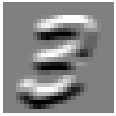

In [12]:
# Lets apply it to all of them
img3_edges = tensor([[apply_kernel(i, j, top_edge) for j in range(1, 27)] for i in range(1, 27)])

# Note the top edges are highlighted
ds.show_image(img3_edges)

<Axes: >

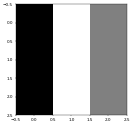

In [13]:
# We can do this for other edges
left_edge = tensor([[-1, 1, 0], [-1, 1, 0], [-1, 1, 0]])

ds.show_image(left_edge, noframe=False)

<Axes: >

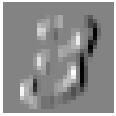

In [14]:
# And apply the left edge kernel
img3_edges = tensor([[apply_kernel(i, j, left_edge) for j in range(1, 27)] for i in range(1, 27)])

# Note the top edges are highlighted
ds.show_image(img3_edges)

Notice that we always lose the outer edge of our image.

## Convolutions in pytorch

Doing convolutions in python will is slow. You can "unroll" input features and kernels into matrices so that a matrix multiplication does your convolution. There is `numpy.im2col` and `torch.nn.functional.unfold` and `pytorch.functional.conv2d`.

In [27]:
import torch.nn.functional as F

# Unroll the input
inp = im3[None, None, :, :].float()  # unfold expects batch and channel dimensions as well
inp_unf = F.unfold(inp, (3, 3))[0]
inp.shape, inp_unf.shape

(torch.Size([1, 1, 28, 28]), torch.Size([9, 676]))

In [35]:
# Unroll the kernel by flattening it into a vector
w = left_edge.view(-1).float()
w.shape

torch.Size([9])

In [36]:
# Do the matrix mult
out_unf = w @ inp_unf
out_unf.shape

torch.Size([676])

<Axes: >

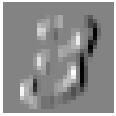

In [37]:
# Squish it back into a matrix, note weve lost pixels
out = out_unf.view(26, 26)
ds.show_image(out)

<Axes: >

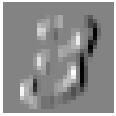

In [63]:
# The same thing as these steps is wraped up in conv2d
out = F.conv2d(inp, left_edge[None, None].float()).squeeze()
ds.show_image(out)

1 2


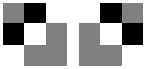

In [68]:
# Diagonals can be define din the same way

diag1_edge = tensor([[0, -1, 1], [-1, 1, 0], [1, 0, 0]])

diag2_edge = tensor([[1, -1, 0], [0, 1, -1], [0, 0, 1]])

ds.show_images([diag1_edge, diag2_edge])

In [78]:
# We can stack up all of the kernels in the batch dim
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])[:, None, ...]
edge_kernels.shape

torch.Size([4, 1, 3, 3])

In [82]:
# Grab a batch of 16 images in the batch dim as well
img_batch = x_imgs[:16][:, None, ...]
img_batch.shape

torch.Size([16, 1, 28, 28])

In [85]:
# And have pytorch do the conv on them all at once
batch_features = F.conv2d(img_batch, edge_kernels)
batch_features.shape

torch.Size([16, 4, 26, 26])

8 8


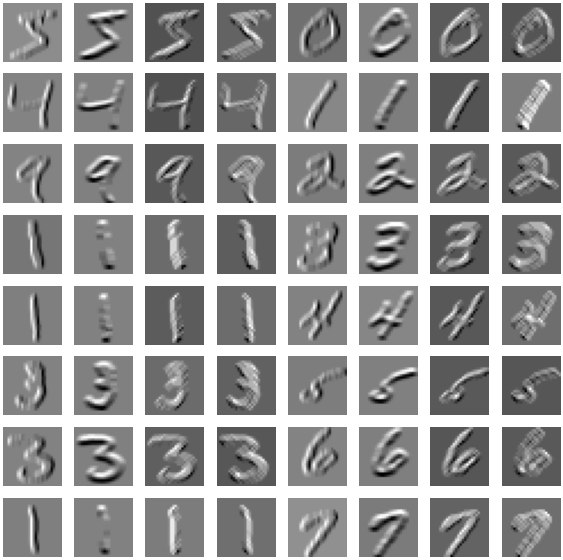

In [91]:
ds.show_images([batch_features[i, j] for i in range(16) for j in range(4)])

## Strides and padding

How do we deal with losing one pixel on each side? We can ad padding. We essentially start our window at [-1,-1] and just assume that these padded values are 0. You can vary the padding with the kernel size to maintain sizes:

- 3x3 kernel + 1px padding = same size
- 5x5 kernel + 3px padding = same size

So we a kernel size of `ks` you need `ks//2` padding the maintain the same size.

You can also move the window by a different amount each time. This is called the stride. Stride 2 convolutions are handy because they reduce the dimensionality of your input by a factor of two. This comes up a lot (autoencoders, most classification architectures).

## Creating the CNN

In [96]:
n_images, n_pixels = x_train.shape
n_categories = y_train.max() + 1
n_hidden = 50

In [100]:
# For our previous sequential linear models (MLP) we did this:
model = nn.Sequential(nn.Linear(n_pixels, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 10))

# This is the equivelant for a convolution
broken_cnn = nn.Sequential(
    nn.Conv2d(1, 30, kernel_size=3, padding=1), nn.ReLU(), nn.Conv2d(30, 10, kernel_size=3, padding=1)
)

In [105]:
# The problem is that the output now isnt 10 probabilities (one for each category)
# Its 10 probabilities for each of 28x28 pixels
broken_cnn(img_batch).shape

# What shall we do?

torch.Size([16, 10, 28, 28])

In [108]:
# |export


def conv(in_channels, out_channels, kernel_size=3, stride=2, act=True):
    """Helper to make a Conv2d with an optional ReLU activation function"""
    res = nn.Conv2d(in_channels, out_channels, stride=stride, kernel_size=kernel_size, padding=kernel_size // 2)
    if act:
        res = nn.Sequential(res, nn.ReLU())

    return res

In [125]:
# Each stride 2 conv halves our grid size until we end up with 16x10x1x1
simple_cnn = nn.Sequential(
    conv(1, 4),  # 14x14
    conv(4, 8),  # 7x7
    conv(8, 16),  # 4x4
    conv(16, 16),  # 2x2
    conv(16, 10, act=False),  # 1x1
    nn.Flatten(),  # Remove extra dims
)

simple_cnn(img_batch).shape

torch.Size([16, 10])

In [134]:
# Now lets setup the training and validation data in a dataset
from torch.utils.data import Dataset

x_imgs = x_train.view(-1, 1, 28, 28)
xv_imgs = x_valid.view(-1, 1, 28, 28)

train_ds = tr.Dataset(x_imgs, y_train)
valid_ds = tr.Dataset(xv_imgs, y_valid)

In [142]:
# |export

# Work out where we can run things and use that as the default device
def_device = "cuda" if torch.cuda.is_available() else "cpu"


def to_device(x, device=def_device):
    """Calls to_device on tensors,lists of tensors, dicts of tensors"""
    if isinstance(x, Mapping):
        return {k: val.to(device) for k, val in x.items()}

    return type(x)(o.to(device) for o in x)


def collate_device(batch):
    """Custom collate that calls the default_collate and puts the tensors onto the gpu if possible"""
    return to_device(default_collate(batch))

In [150]:
# Create our dataloaders and optimizer
from torch import optim

batch_size = 256
lr = 0.4

train_dl, valid_dl = tr.get_dls(train_ds, valid_ds, batch_size, collate_fn=collate_device)
opt = optim.SGD(simple_cnn.parameters(), lr=lr)

In [156]:
# And get our fit func to train away
loss, acc = tr.fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)

epoch: 0, loss: 2.29018125038147, acc: 0.11356
epoch: 1, loss: 0.4546276520729065, acc: 0.856620000038147
epoch: 2, loss: 0.30435046555042267, acc: 0.903360000038147
epoch: 3, loss: 0.23735798338890077, acc: 0.9244
epoch: 4, loss: 0.1510869704604149, acc: 0.953560000038147


In [157]:
# Lets try running it some more with a reduce learning rage
opt = optim.SGD(simple_cnn.parameters(), lr=lr / 4)
loss, acc = tr.fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)

epoch: 0, loss: 0.10416874858856201, acc: 0.967620000038147
epoch: 1, loss: 0.10144357597351074, acc: 0.9678200000381469
epoch: 2, loss: 0.10280992586135865, acc: 0.967900000038147
epoch: 3, loss: 0.09446246700763702, acc: 0.97014
epoch: 4, loss: 0.08714750488698482, acc: 0.97256


Pretty close to our MLP.

## Understanding convolution arithmetic

With an input size of `64x1x28x28` and axes of `batch,channel,height,width`. This is often represented as `NCHW`. Tensorflow uses `NHWC` - channels last. Channels-last is faster for many models so has become an option in pytorch too.

Our first conv has have input 1 channel, 4 out channels and a 3x3 kernel.

In [160]:
conv1 = simple_cnn[0][0]
conv1, conv1.weight.shape, conv1.bias.shape

(Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 torch.Size([4, 1, 3, 3]),
 torch.Size([4]))

The receptive field is the area of an image involved in the calculation of a layer. So on cell is created by a 3x3 area in the previous (and so on). Remember that there are also potentially multiple kernels.

The deeper we are in the network, the larger the receptive field for an activation in that layer.